In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from joblib import dump, load
from xgboost import XGBClassifier
plt.rcParams['figure.figsize'] = [20,10]

In [2]:
data = pd.read_csv('transactions_train.csv')
responseVar = data.isFraud.to_numpy()
responseVar
data['deltaBalanceOrig'] = data.newbalanceOrig - data.oldbalanceOrig
data['deltaBalanceDest'] = -data.newbalanceDest + data.oldbalanceDest
data['prevStep'] = data['step'].shift(1)
data['prevAmt'] = data['amount'].shift(1)
data['prevType'] = 0

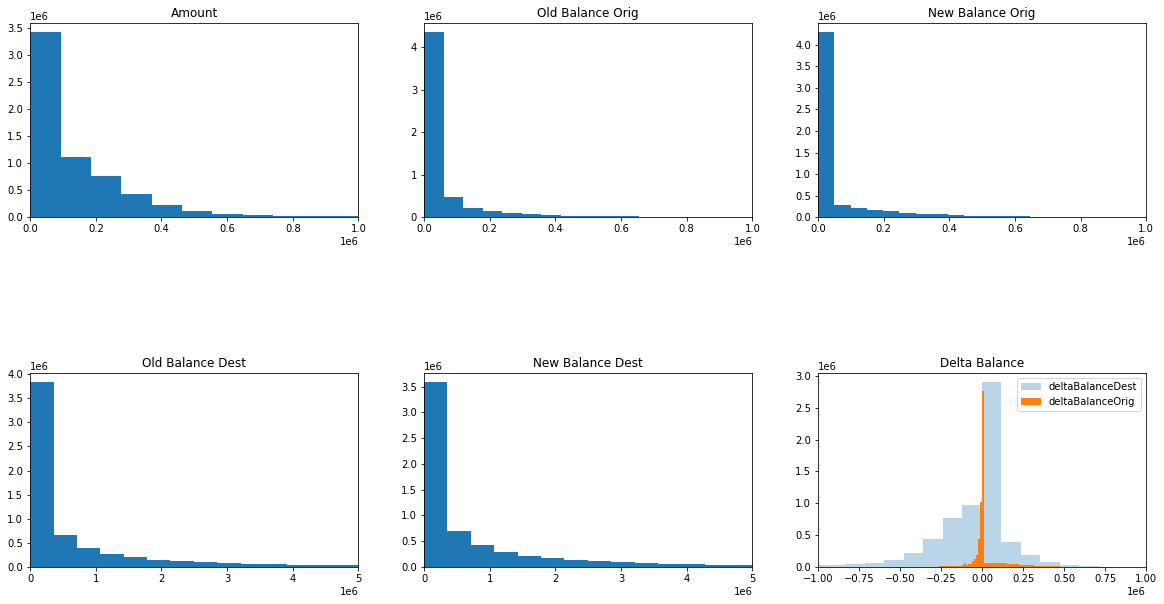

In [3]:
fig,((ax,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3)
fig.subplots_adjust(hspace=0.8)
ax.hist(x=data['amount'],bins=1000,label='amount')
ax.set_xlim(0,1e6)
ax.set_title('Amount')
ax1.hist(x=data['oldbalanceOrig'],bins=1000,label='oldbalanceOrig')
ax1.set_xlim(0,1e6)
ax1.set_title('Old Balance Orig')
ax2.hist(x=data['newbalanceOrig'],bins=1000,label='newbalanceOrig')
ax2.set_xlim(0,1e6)
ax2.set_title('New Balance Orig')
ax3.hist(x=data['oldbalanceDest'],bins=1000,label='oldbalanceDest')
ax3.set_xlim(0,0.5e7)
ax3.set_title('Old Balance Dest')
ax4.hist(x=data['newbalanceDest'],bins=1000,label='newbalanceDest')
ax4.set_xlim(0,0.5e7)
ax4.set_title('New Balance Dest')
ax5.hist(x=data['deltaBalanceDest'],bins=1000,label='deltaBalanceDest',alpha=0.3)
ax5.hist(x=data['deltaBalanceOrig'],bins=1000,label='deltaBalanceOrig')
ax5.set_xlim(-1e6,1e6)
ax5.set_title('Delta Balance')
ax5.legend()

plt.show()

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,deltaBalanceOrig,deltaBalanceDest,prevStep,prevAmt,prevType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,-9839.64,0.0,NaN,NaN,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,-1864.28,0.0,1.0,9839.64,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,-181.00,0.0,1.0,1864.28,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,-181.00,21182.0,1.0,181.00,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,-11668.14,0.0,1.0,181.00,0


In [5]:
features = data.loc[:,['amount','deltaBalanceDest','step','prevStep','type',
                       'oldbalanceOrig','newbalanceOrig','newbalanceDest','oldbalanceDest','deltaBalanceOrig',
                    'prevAmt','prevType','nameOrig','nameDest']]
features.shape

(6351193, 14)

In [9]:
cat_scaler = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan).fit(features[
    ['type','nameOrig','nameDest']])
features[['type','nameOrig','nameDest']] = cat_scaler.transform(features[['type','nameOrig','nameDest']])
features['prevType'] = features['type'].shift(1)
features

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,prevType,nameOrig,nameDest
0,9839.64,0.00,1,NaN,3.0,170136.00,160296.36,0.00,0.00,-9839.64,NaN,NaN,756432.0,1658347.0
1,1864.28,0.00,1,1.0,3.0,21249.00,19384.72,0.00,0.00,-1864.28,9839.64,3.0,2185056.0,1730065.0
2,181.00,0.00,1,1.0,4.0,181.00,0.00,0.00,0.00,-181.00,1864.28,3.0,1000312.0,438228.0
3,181.00,21182.00,1,1.0,1.0,181.00,0.00,0.00,21182.00,-181.00,181.00,4.0,5817752.0,390383.0
4,11668.14,0.00,1,1.0,3.0,41554.00,29885.86,0.00,0.00,-11668.14,181.00,1.0,3439787.0,826594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351188,162326.52,0.00,699,699.0,4.0,162326.52,0.00,0.00,0.00,-162326.52,573.88,3.0,1827404.0,394697.0
6351189,162326.52,-162326.52,699,699.0,1.0,162326.52,0.00,162326.52,0.00,-162326.52,162326.52,4.0,1745078.0,406977.0
6351190,2763398.31,0.00,699,699.0,4.0,2763398.31,0.00,0.00,0.00,-2763398.31,162326.52,1.0,4955293.0,457660.0
6351191,2763398.31,-2763398.31,699,699.0,1.0,2763398.31,0.00,3102913.66,339515.35,-2763398.31,2763398.31,4.0,1610912.0,409341.0


In [10]:
seed = 42
Xtrain,Xtest,ytrain,ytest = train_test_split(features,responseVar,test_size=0.2,stratify=responseVar, random_state=seed)

In [14]:
mdl = XGBClassifier(use_label_encoder=False,verbosity=2)
mdl.fit(Xtrain,ytrain)

[13:58:26] INFO: ../src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[13:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[13:58:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[13:58:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[13:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[13:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[14:04:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[14:04:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:05:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[14:05:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[14:05:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[14:05:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[14:05:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[14:05:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=2)

In [15]:
mdl.score(Xtrain,ytrain)

0.9999960637313386

In [16]:
preds = mdl.predict(Xtest)
acc = accuracy_score(ytest,preds)
f1 = f1_score(ytest,preds)
prec = precision_score(ytest,preds)
recall = recall_score(ytest,preds)
AUC = roc_auc_score(ytest,preds)
print(acc, f1, prec, recall, AUC)

0.9999748078904837 0.9896574014221073 0.9871050934880722 0.9922229423201555 0.9961035890512039


In [17]:
dump(mdl,'XGBoostModelFeatures14.joblib')

['XGBoostModelFeatures14.joblib']

In [18]:
print(np.c_[features.columns,mdl.feature_importances_])

[['amount' 0.032177623361349106]
 ['deltaBalanceDest' 0.0671234279870987]
 ['step' 0.016034027561545372]
 ['prevStep' 0.0036841456312686205]
 ['type' 0.1147078275680542]
 ['oldbalanceOrig' 0.06193464621901512]
 ['newbalanceOrig' 0.1153772845864296]
 ['newbalanceDest' 0.22096405923366547]
 ['oldbalanceDest' 0.005844469647854567]
 ['deltaBalanceOrig' 0.051363054662942886]
 ['prevAmt' 0.031442366540431976]
 ['prevType' 0.27391517162323]
 ['nameOrig' 0.0016412114491686225]
 ['nameDest' 0.0037906228099018335]]


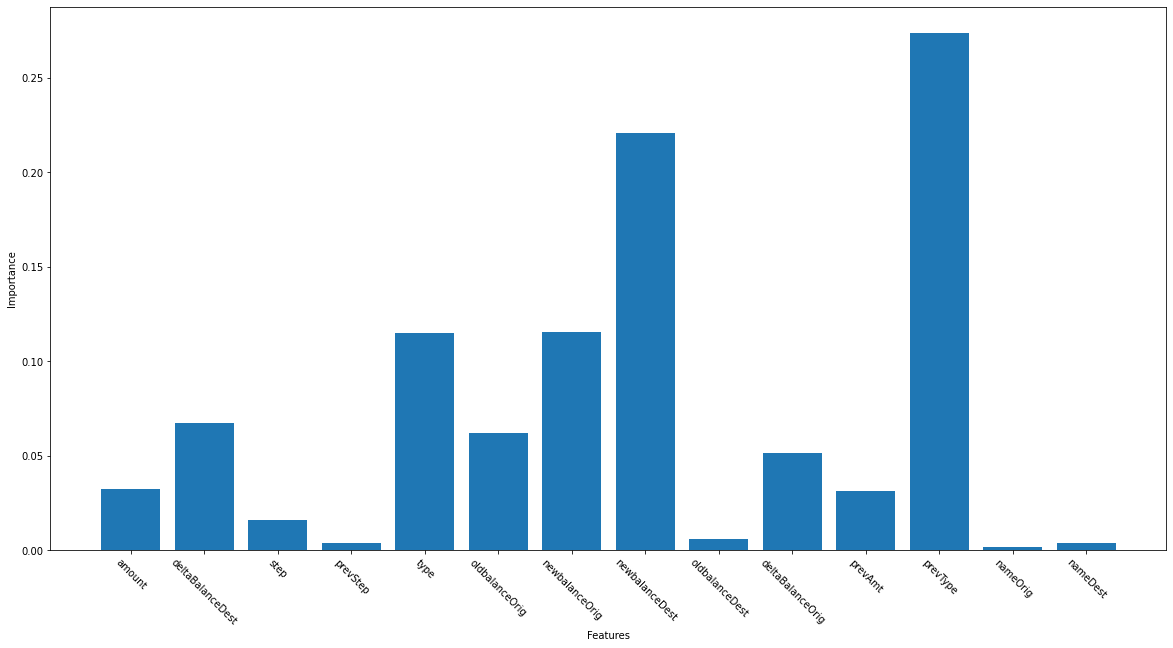

In [20]:
plt.bar(features.columns,mdl.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=-45)
plt.show()

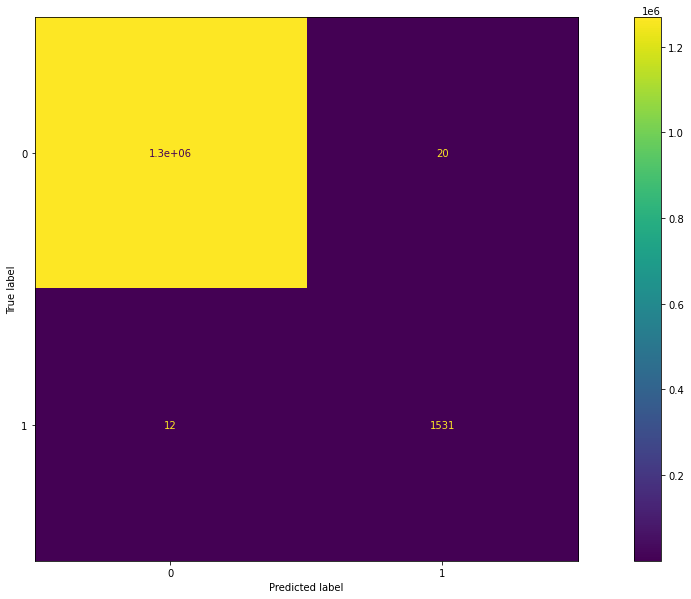

In [21]:
cm = confusion_matrix(ytest, preds, labels=mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mdl.classes_)
disp.plot()
plt.show()

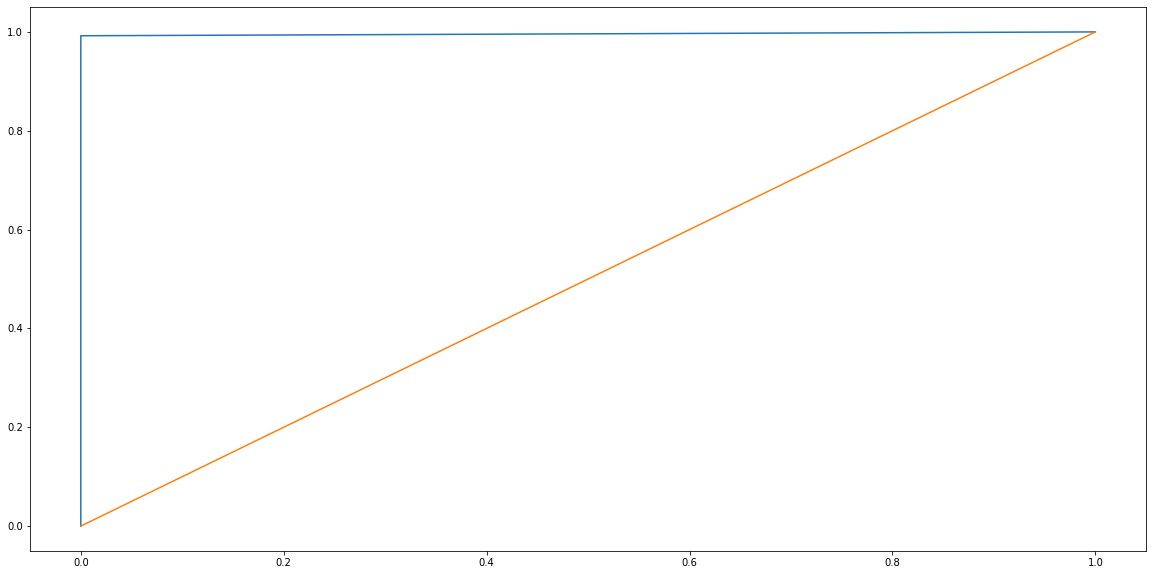

In [22]:
fpr, tpr, thresh = roc_curve(ytest,preds)
f, ax = plt.subplots(1)
ax.plot(fpr,tpr)
ax.plot([0,1])
plt.show()

In [24]:
featuresReduced = features[['amount','deltaBalanceDest','step','type', 'oldbalanceOrig',
                            'newbalanceOrig','newbalanceDest','deltaBalanceOrig',
                            'prevAmt','prevType']]
featuresReduced

,amount,deltaBalanceDest,step,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,deltaBalanceOrig,prevAmt,prevType
0,9839.64,0.00,1,3.0,170136.00,160296.36,0.00,-9839.64,NaN,NaN
1,1864.28,0.00,1,3.0,21249.00,19384.72,0.00,-1864.28,9839.64,3.0
2,181.00,0.00,1,4.0,181.00,0.00,0.00,-181.00,1864.28,3.0
3,181.00,21182.00,1,1.0,181.00,0.00,0.00,-181.00,181.00,4.0
4,11668.14,0.00,1,3.0,41554.00,29885.86,0.00,-11668.14,181.00,1.0
...,...,...,...,...,...,...,...,...,...,...
6351188,162326.52,0.00,699,4.0,162326.52,0.00,0.00,-162326.52,573.88,3.0
6351189,162326.52,-162326.52,699,1.0,162326.52,0.00,162326.52,-162326.52,162326.52,4.0
6351190,2763398.31,0.00,699,4.0,2763398.31,0.00,0.00,-2763398.31,162326.52,1.0
6351191,2763398.31,-2763398.31,699,1.0,2763398.31,0.00,3102913.66,-2763398.31,2763398.31,4.0


In [27]:
XtrainReduced = Xtrain[['amount','deltaBalanceDest','step','type', 'oldbalanceOrig',
                            'newbalanceOrig','newbalanceDest','deltaBalanceOrig',
                            'prevAmt','prevType']]
XtestReduced = Xtest[['amount','deltaBalanceDest','step','type', 'oldbalanceOrig',
                            'newbalanceOrig','newbalanceDest','deltaBalanceOrig',
                            'prevAmt','prevType']]

In [29]:
mdlReduced = XGBClassifier(use_label_encoder=False,verbosity=2)
mdlReduced.fit(XtrainReduced,ytrain)

[14:16:57] INFO: ../src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[14:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[14:17:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[14:17:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[14:17:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[14:17:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[14:21:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[14:21:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[14:21:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[14:21:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[14:21:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[14:21:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[14:21:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[14:21:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[14:22:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=2)

In [31]:
mdlReduced.score(XtrainReduced,ytrain)

0.9999948828507402

In [32]:
preds = mdlReduced.predict(XtestReduced)
acc = accuracy_score(ytest,preds)
f1 = f1_score(ytest,preds)
prec = precision_score(ytest,preds)
recall = recall_score(ytest,preds)
AUC = roc_auc_score(ytest,preds)
print(acc, f1, prec, recall, AUC)

0.9999787441575956 0.9912536443148688 0.9909326424870466 0.9915748541801686 0.9957819096138725


In [33]:
print(np.c_[featuresReduced.columns,mdlReduced.feature_importances_])

[['amount' 0.033475954085588455]
 ['deltaBalanceDest' 0.07174070179462433]
 ['step' 0.01637008972465992]
 ['type' 0.12290298193693161]
 ['oldbalanceOrig' 0.06575964391231537]
 ['newbalanceOrig' 0.1437990665435791]
 ['newbalanceDest' 0.1505773812532425]
 ['deltaBalanceOrig' 0.05797433480620384]
 ['prevAmt' 0.03178185597062111]
 ['prevType' 0.3056180477142334]]


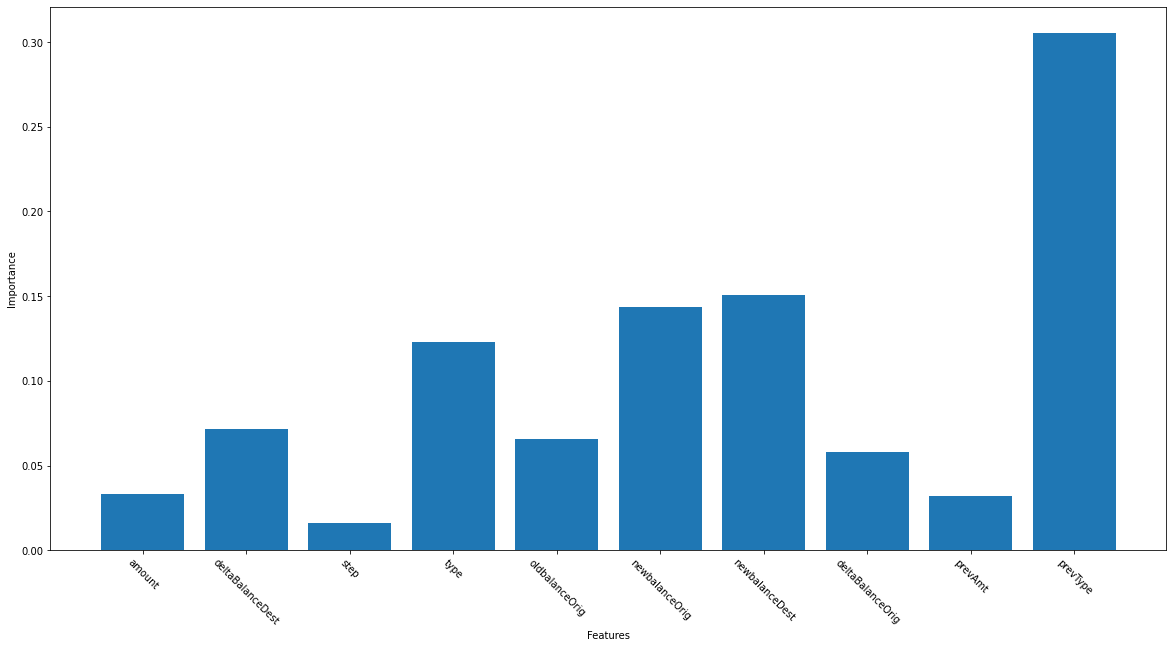

In [34]:
plt.bar(featuresReduced.columns,mdlReduced.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=-45)
plt.show()

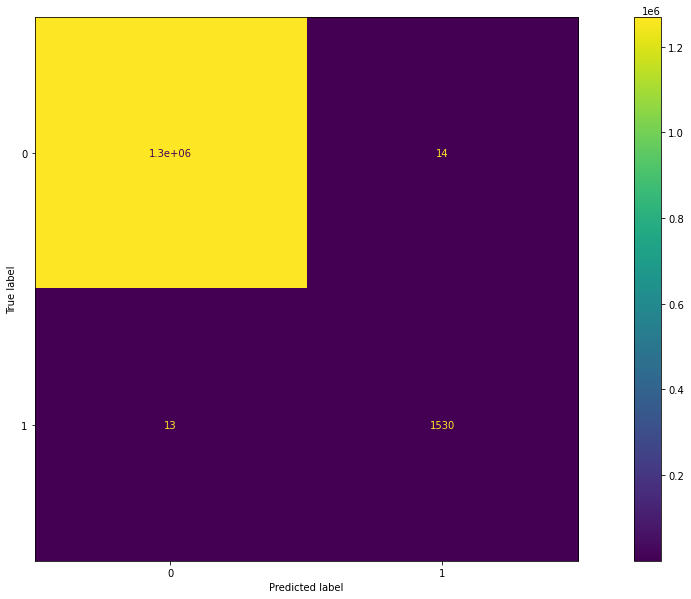

In [35]:
cm = confusion_matrix(ytest, preds, labels=mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mdl.classes_)
disp.plot()
plt.show()

In [36]:
dump(mdlReduced,'XGBoostModelReduced.joblib')

['XGBoostModelReduced.joblib']

In [37]:
cat_scaler.categories_

[array([0., 1., 2., 3., 4.]),
 array([0.000000e+00, 1.000000e+00, 2.000000e+00, ..., 6.341904e+06,
        6.341905e+06, 6.341906e+06]),
 array([0.000000e+00, 1.000000e+00, 2.000000e+00, ..., 2.716807e+06,
        2.716808e+06, 2.716809e+06])]

In [ ]:
nameOrigCount = data.groupby('nameDest',sort=True).size()
nameMaxOrig = nameOrigCount.idxmax()
nameMaxOrig

In [ ]:
w = nameOrigCount.sort_values(ascending=False)
w[:50]

In [39]:
Xtrain[ytrain==1]

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,prevType,nameOrig,nameDest
1237398,3892156.30,-3892156.30,134,134.0,1.0,3892156.30,0.0,9555383.66,5663227.36,-3892156.30,3892156.30,4.0,2251441.0,97428.0
6201733,736677.36,0.00,578,578.0,4.0,736677.36,0.0,0.00,0.00,-736677.36,890.06,3.0,5356399.0,266697.0
6062100,1673066.07,0.00,502,502.0,4.0,1673066.07,0.0,0.00,0.00,-1673066.07,16234.87,3.0,2030246.0,97892.0
1059607,204675.48,-204675.48,107,107.0,1.0,204675.48,0.0,314055.91,109380.43,-204675.48,204675.48,4.0,4070179.0,486656.0
5996413,287720.41,0.00,425,425.0,4.0,287720.41,0.0,0.00,0.00,-287720.41,460434.46,1.0,2178903.0,186233.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3681231,1567591.24,-1567591.24,276,276.0,1.0,1567591.24,0.0,2390344.31,822753.07,-1567591.24,1567591.24,4.0,5713791.0,177648.0
1313408,199878.85,-199878.85,136,136.0,1.0,199878.85,0.0,603148.54,403269.69,-199878.85,199878.85,4.0,1883627.0,258680.0
6260572,10000000.00,-10000000.00,608,608.0,1.0,10000000.00,0.0,10000000.00,0.00,-10000000.00,10000000.00,4.0,1911104.0,384019.0
6030116,7009.93,0.00,473,473.0,4.0,7009.93,0.0,0.00,0.00,-7009.93,179700.14,1.0,4799053.0,365296.0
